In [14]:
!pip install AugmentedSocialScientist pandas numpy wordcloud matplotlib spacy nltk
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 28.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


# Description des annotations

## Description des catégories en nombre et recodage

In [1]:
import pandas as pd
simplify_labels = False
take_sentence_with_context = True

if(take_sentence_with_context):
    text_var = "sentence_text"
else:
    text_var = "sentence"

current_annotations_file = "../data/intermediate/annotations/personne_1400annotations_2024-03-27_ActiveTigger.csv"

annotations_file = pd.read_csv(current_annotations_file)
# defining the label variable, with a possible recategorization before training
label_categories = {
    "Poubelle" : "Anything but personne à protéger",
    "Humain comme empathie" : "Anything but personne à protéger",
    "Sentiment humain": "Anything but personne à protéger",
    "Genre/espèce humaine": "Anything but personne à protéger",
    "Matériel biologique": "Anything but personne à protéger",
    "Individu": "Anything but personne à protéger",
    "Individu ou sujet" : "Anything but personne à protéger",
    "Agent responsable":"Anything but personne à protéger",
    "Personne responsable et autonome" : "Anything but personne à protéger",
    "Personne relationnelle": "Anything but personne à protéger",
    "Personne à protéger":"Personne à protéger"
}

if(simplify_labels):
    annotations_file['label'] = annotations_file['Personne'].map(label_categories)
else:
    annotations_file['label'] = annotations_file['Personne']

# defining text variable    
annotations_file['text'] = annotations_file[text_var]


annotations_file.sample(5)

sentence_id                          Personne  \
160       1360377                          Poubelle   
1487       570699                               NaN   
1669      1240074                               NaN   
1901      1210514                               NaN   
238        870021  Personne responsable et autonome   

                                          sentence_text  \
160   Des études ont -\nelles été menées sur la qual...   
1487  7,9\n6,2\n(1) Länder de la République fédérale...   
1669  », précise le Génoscope, soulignant que la not...   
1901  Les demandes de donner la mort formulées par u...   
238   Questions éthiques \nVI.1. Les différentes fac...   

                                 label  \
160                           Poubelle   
1487                               NaN   
1669                               NaN   
1901                               NaN   
238   Personne responsable et autonome   

                                                   text  
160   Des études ont -\nelles été menées sur la qual...  
1487  7,9\n6,2\n(1) Länder de la République fédérale...  
1669  », précise le Génoscope, soulignant que la not...  
1901  Les demandes de donner la mort formulées par u...  
238   Questions éthiques \nVI.1. Les différentes fac...

In [2]:
# filtering out not annotated (na) and some categories
annotations = annotations_file.dropna()
annotations = annotations[~annotations["Personne"].isin(["Poubelle"])]
annotations.sample(5)

sentence_id                          Personne  \
397      1281047               Personne à protéger   
130       500232  Personne responsable et autonome   
699      1280766               Personne à protéger   
766       600263              Genre/espèce humaine   
646      1280759                 Individu ou sujet   

                                         sentence_text  \
397  54 \n 10. Comment une personne âgée pourrait -...   
130  La stérilisation constituet-elle une " violenc...   
699  Le résultat de cette inadaptation temporelle e...   
766  L'utilisation des tests génétiques dans le cad...   
646  Force est de constater que les logiques actuel...   

                                label  \
397               Personne à protéger   
130  Personne responsable et autonome   
699               Personne à protéger   
766              Genre/espèce humaine   
646                 Individu ou sujet   

                                                  text  
397  54 \n 10. Comment une personne âgée pourrait -...  
130  La stérilisation constituet-elle une " violenc...  
699  Le résultat de cette inadaptation temporelle e...  
766  L'utilisation des tests génétiques dans le cad...  
646  Force est de constater que les logiques actuel...

In [3]:
annotations["Personne"].value_counts()

Personne
Individu ou sujet                   232
Personne à protéger                 230
Corps humain                        229
Personne relationnelle              222
Personne responsable et autonome    220
Genre/espèce humaine                214
Sentiment humain                     35
Name: count, dtype: int64

In [4]:
annotations["label"].value_counts()

label
Individu ou sujet                   232
Personne à protéger                 230
Corps humain                        229
Personne relationnelle              222
Personne responsable et autonome    220
Genre/espèce humaine                214
Sentiment humain                     35
Name: count, dtype: int64

## Description lexicographique

In [5]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the French language model from spaCy
nlp = spacy.load("fr_core_news_sm")

# Function to lemmatize text
def lemmatize_text(text):
    custom_stop_words = ["e"]
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token in custom_stop_words])
    return lemmatized

# Apply lemmatization to the 'text' column
annotations['lemmatized_text'] = annotations['text'].apply(lemmatize_text)

In [8]:
import re
def filter_words(text):

    # Compile regex pattern with word boundaries
    pattern = re.compile(r'\b(?:' + '|'.join(words_to_filter) + r')\b', flags=re.IGNORECASE)
    return pattern.sub('', text)

In [9]:
words_to_filter = ['l','e','ceue']

annotations["lemmatized_text"]=annotations["lemmatized_text"].apply(filter_words)

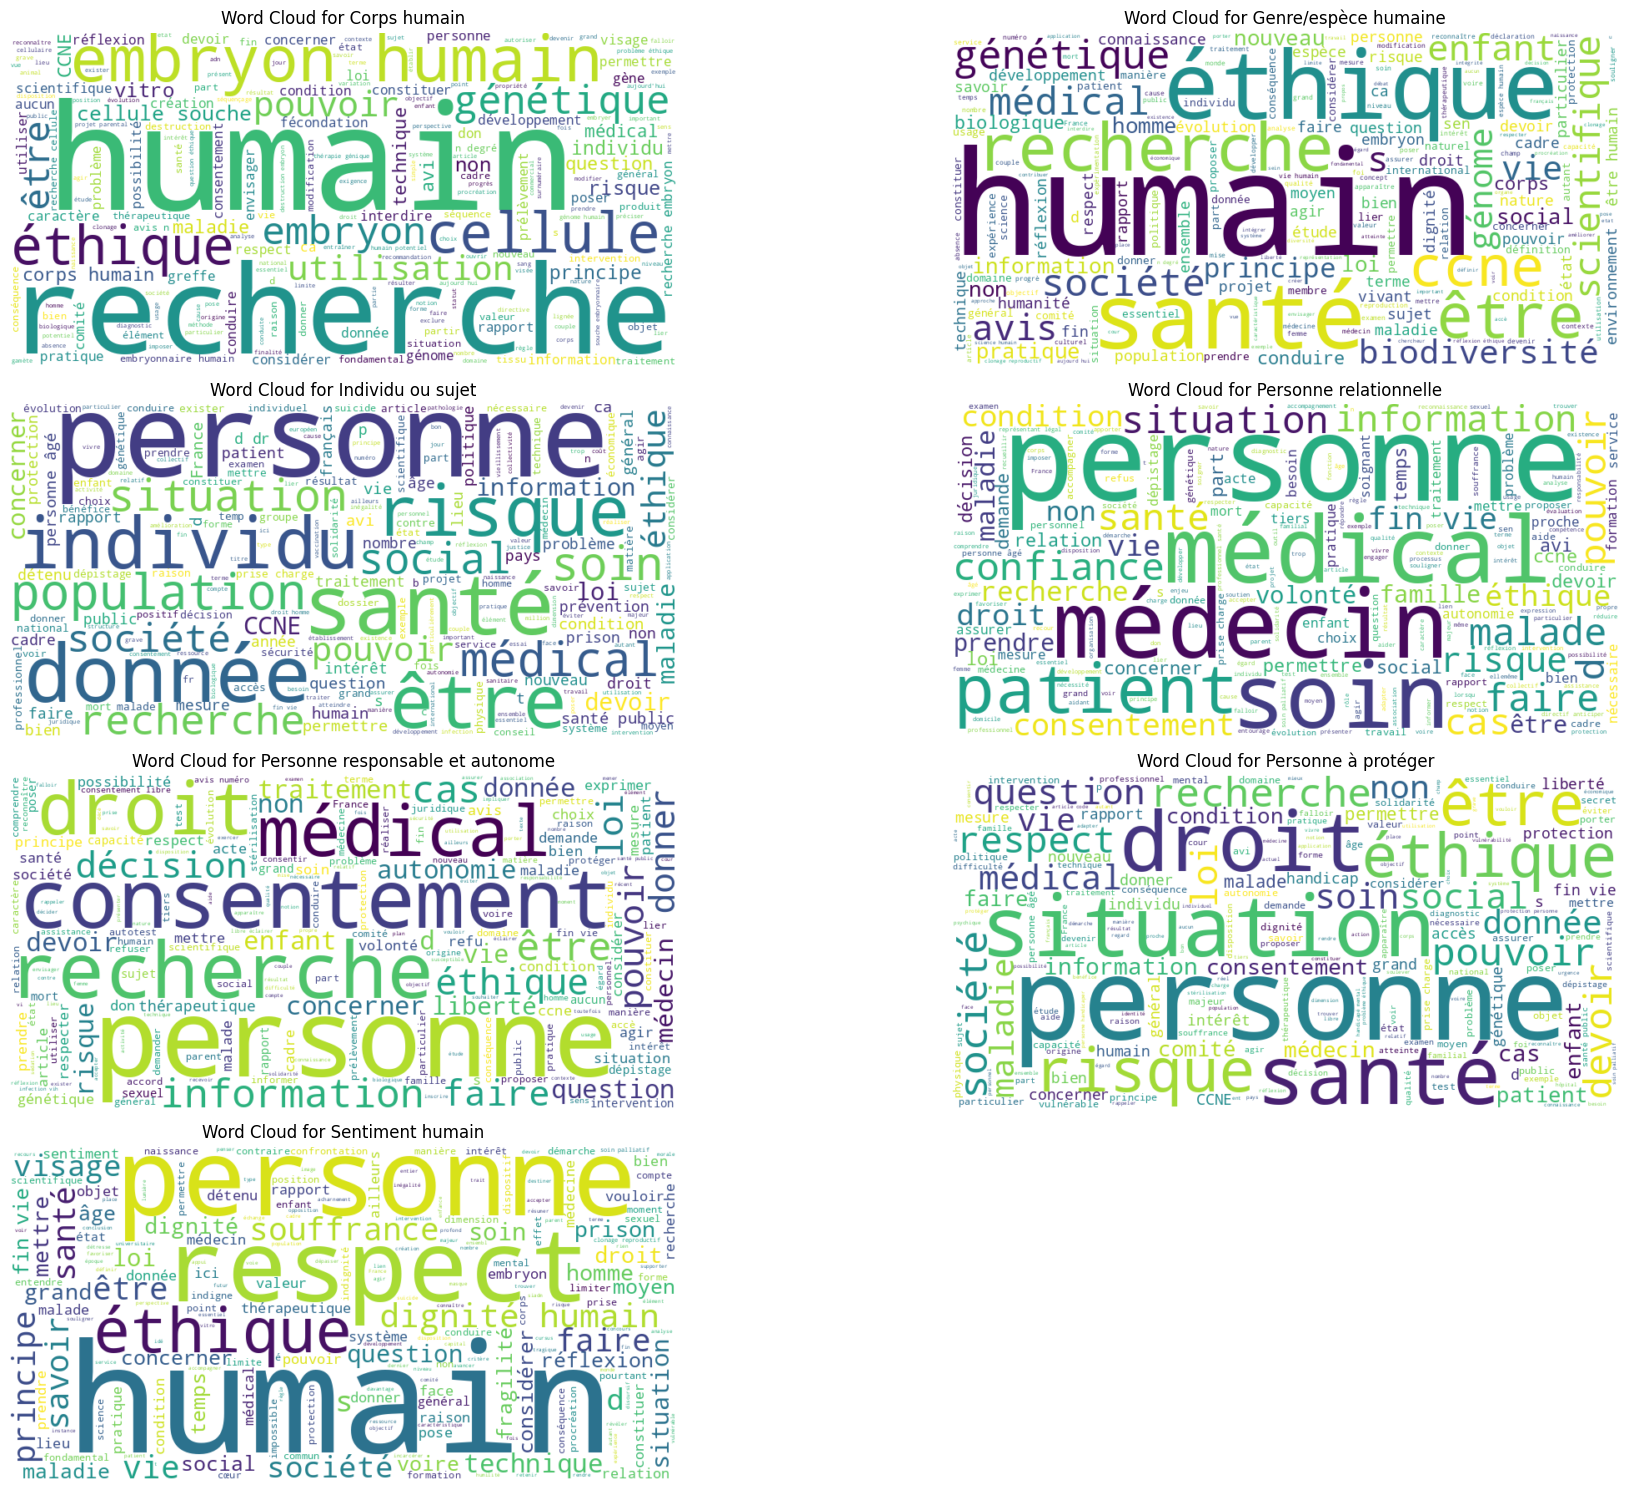

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Determine the number of categories
num_categories = annotations['Personne'].nunique()

# Setup plot grid (2 columns, 3 rows max)
cols = 2
rows = round(num_categories/cols)
# Create the figure with a gridspec
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(rows, cols, figure=fig)

# Counter for subplot index
subplot_index = 0

for category, group in annotations.groupby('Personne'):
    combined_text = " ".join(group['lemmatized_text'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)
    
    # Calculate row, col index for the current subplot
    row = subplot_index // cols
    col = subplot_index % cols
    
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {category}')
    ax.axis('off')
    
    subplot_index += 1

plt.tight_layout()
plt.show()

In [11]:
words_to_filter = ['recherche','humain','médical','médecin','personne','soin','éthique','santé','droit','l','e','ceue']

annotations["lemmatized_text_without_big_words"]=annotations["lemmatized_text"].apply(filter_words)


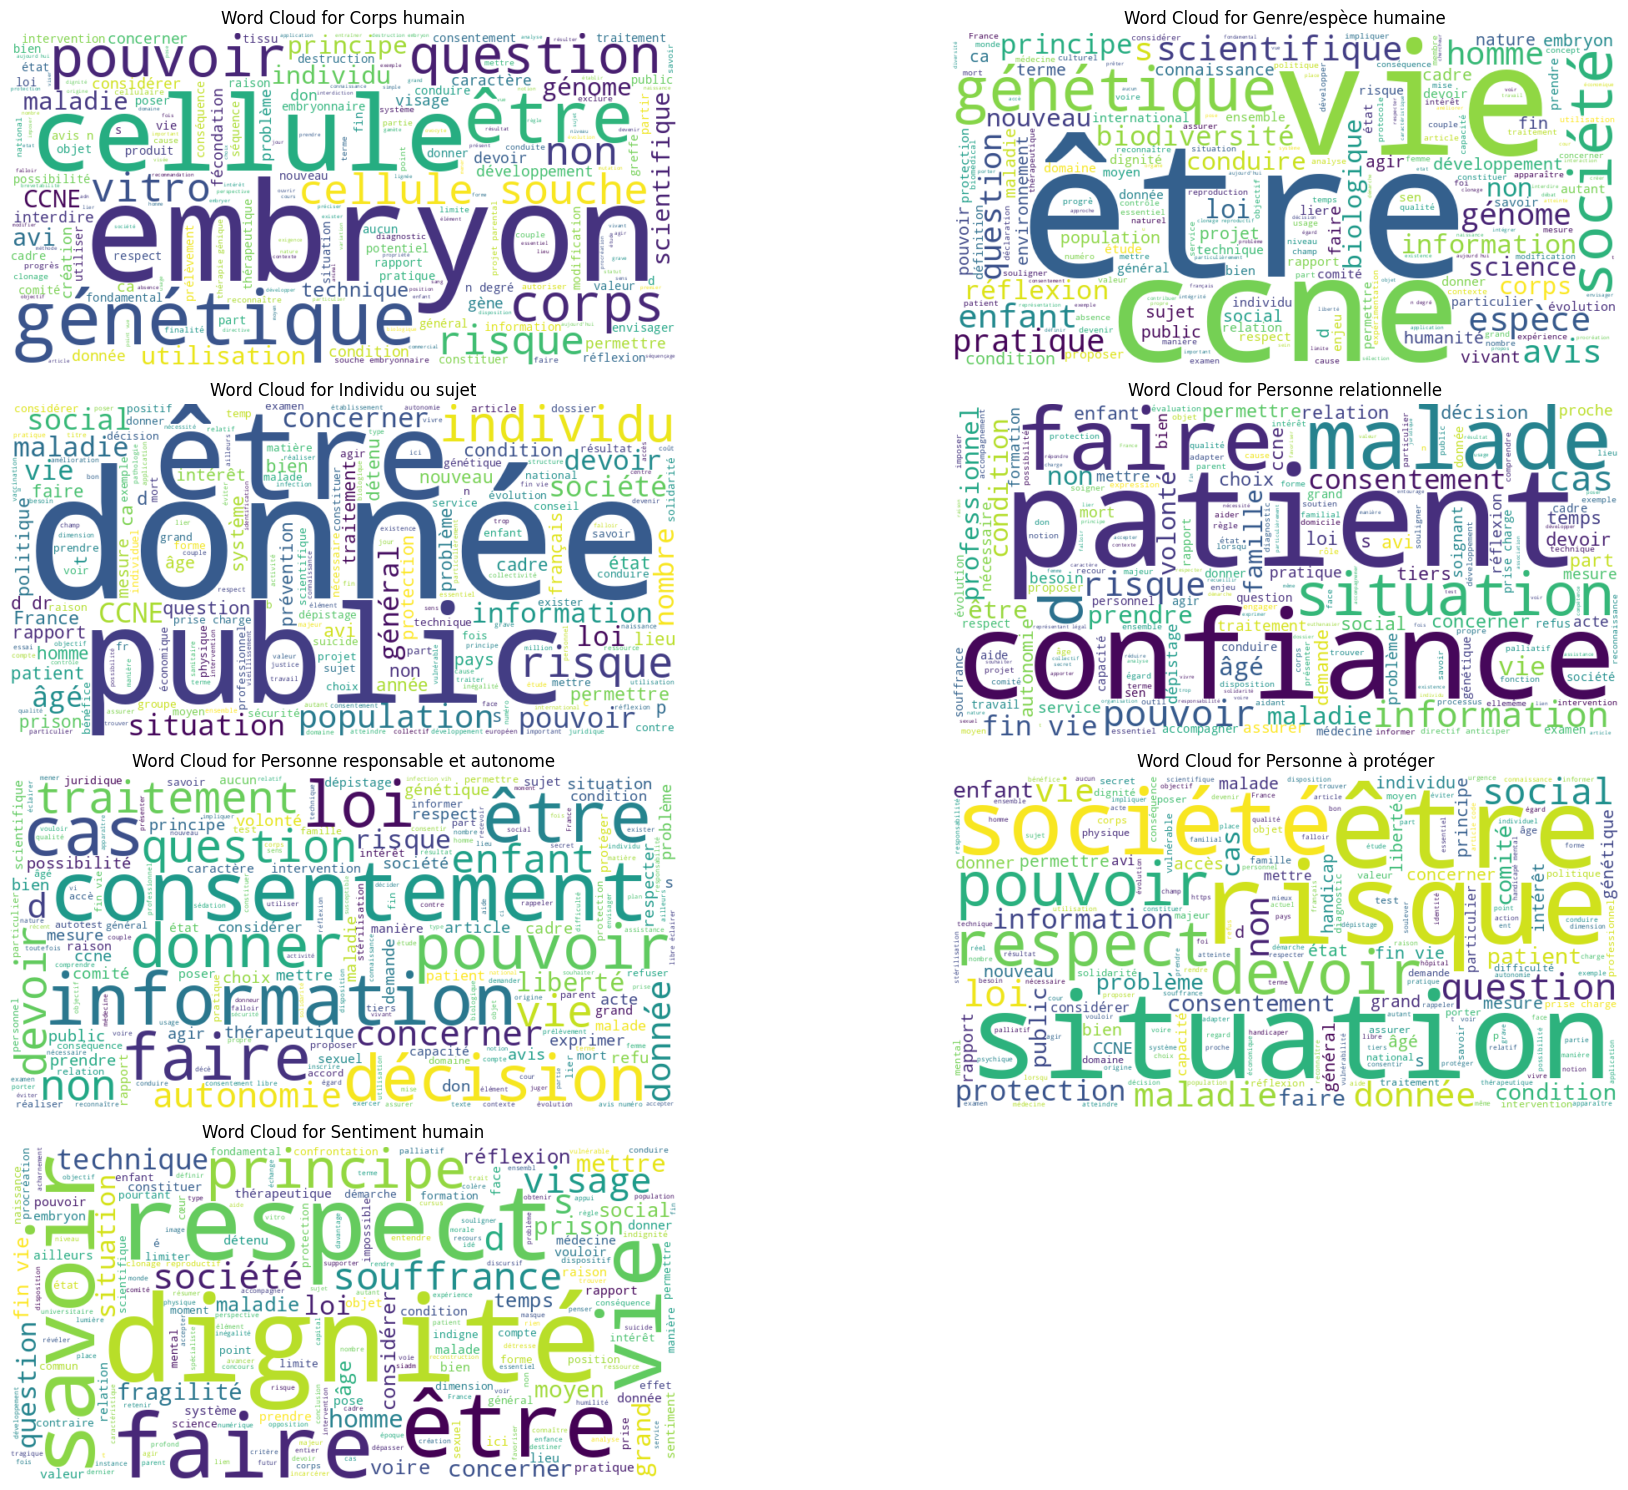

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Determine the number of categories
num_categories = annotations['Personne'].nunique()

# Setup plot grid (2 columns, 3 rows max)
cols = 2
rows = round(num_categories/cols)
# Create the figure with a gridspec
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(rows, cols, figure=fig)

# Counter for subplot index
subplot_index = 0

for category, group in annotations.groupby('Personne'):
    combined_text = " ".join(group['lemmatized_text_without_big_words'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)
    
    # Calculate row, col index for the current subplot
    row = subplot_index // cols
    col = subplot_index % cols
    
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {category}')
    ax.axis('off')
    
    subplot_index += 1

plt.tight_layout()
plt.show()

# Bert classification

In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda

cuda.get_device_name(0)

'Tesla T4'

In [8]:
from sklearn.model_selection import train_test_split
 
train_data, test_data = train_test_split(annotations, train_size=0.80)

In [9]:
from AugmentedSocialScientist.models import Camembert

bert = Camembert()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


There are 1 GPU(s) available.
We will use GPU 0: Tesla T4


In [10]:
batch_size = 16
train_loader = bert.encode(train_data.text.values,
train_data.label.values, batch_size=batch_size)

  0%|          | 0/1105 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1105 [00:00<?, ?it/s]

label ids: {'Corps humain': 0, 'Genre/espèce humaine': 1, 'Individu ou sujet': 2, 'Personne relationnelle': 3, 'Personne responsable et autonome': 4, 'Personne à protéger': 5, 'Sentiment humain': 6}


In [11]:
test_loader = bert.encode(test_data.text.values,
test_data.label.values, batch_size=batch_size)

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

label ids: {'Corps humain': 0, 'Genre/espèce humaine': 1, 'Individu ou sujet': 2, 'Personne relationnelle': 3, 'Personne responsable et autonome': 4, 'Personne à protéger': 5, 'Sentiment humain': 6}


In [12]:
scores = bert.run_training(
    train_loader,
    test_loader,
    n_epochs=3,
    lr=2e-5,
    random_state=42,
    save_model_as='clickbait'
    )

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/mamba/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 3 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:56.

  Average training loss: 1.86
  Training took: 0:01:37

Running Validation...

  Average test loss: 1.76
  Validation took: 0:00:07
                                  precision    recall  f1-score   support

                    Corps humain       0.60      0.86      0.70        50
            Genre/espèce humaine       0.58      0.28      0.38        39
               Individu ou sujet       0.50      0.44      0.47        45
          Personne relationnelle       0.19      0.93      0.32        29
Personne responsable et autonome       0.50      0.02      0.04        50
             Personne à protéger       0.00      0.00      0.00        55
                Sentiment humain       0.00      0.00      0.00         9

                        accuracy                           0.37       277
                       macro avg       0.34      0.36      0.27       277
                    weighted avg   

/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

  Batch    40  of     70.    Elapsed: 0:00:59.

  Average training loss: 1.68
  Training took: 0:01:43

Running Validation...

  Average test loss: 1.60
  Validation took: 0:00:08
                                  precision    recall  f1-score   support

                    Corps humain       0.62      0.96      0.75        50
            Genre/espèce humaine       0.62      0.46      0.53        39
               Individu ou sujet       0.59      0.42      0.49        45
          Personne relationnelle       0.21      0.86      0.34        29
Personne responsable et autonome       0.38      0.12      0.18        50
             Personne à protéger       0.40      0.04      0.07        55
                Sentiment humain       0.00      0.00      0.00         9

                        accuracy                           0.43       277
                       macro avg       0.40      0.41      0.34       277
                    weighted avg       0.46      0.43      0.37       277


==

/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

  Batch    40  of     70.    Elapsed: 0:01:01.

  Average training loss: 1.56
  Training took: 0:01:45

Running Validation...

  Average test loss: 1.55
  Validation took: 0:00:07
                                  precision    recall  f1-score   support

                    Corps humain       0.65      0.96      0.77        50
            Genre/espèce humaine       0.72      0.46      0.56        39
               Individu ou sujet       0.56      0.42      0.48        45
          Personne relationnelle       0.21      0.93      0.35        29
Personne responsable et autonome       0.36      0.10      0.16        50
             Personne à protéger       0.33      0.02      0.03        55
                Sentiment humain       0.00      0.00      0.00         9

                        accuracy                           0.43       277
                       macro avg       0.40      0.41      0.34       277
                    weighted avg       0.46      0.43      0.37       277


Tr

/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

In [12]:
import numpy as np
pred_data = annotations_file[annotations_file["label"].isna()][["text"]].dropna()
pred_loader = bert.encode(pred_data.text.values, batch_size=batch_size)
pred_proba = bert.predict_with_model(pred_loader, model_path='./models/clickbait')
pred_data['pred_label'] = np.argmax(pred_proba, axis=1)
pred_data['pred_proba'] = np.max(pred_proba, axis=1)

  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

label ids: {'Anything but personne à protéger': 0, 'Personne à protéger': 1}


In [13]:
pred_data["pred_proba"].describe()

count    798.000000
mean       0.827895
std        0.005984
min        0.803698
25%        0.824069
50%        0.828583
75%        0.832703
max        0.841079
Name: pred_proba, dtype: float64

In [14]:
pd.set_option('display.max_colwidth', None)  # Use None to show all the text, or set a large number

pred_data

text  \
700                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     S’il semble dès lors naïf de penser que le sentiment de soi est dépendant \nd’une augmentation ou d’une diminution quelconque, on ne peut en revanche exclure que ce sentiment \npuisse être modifié quand un seuil technique, par la prise régulière et prolongée de médicaments \nnotamme nt, est franchi. Il importe donc de tenir compte de toutes les modifications du comportement \nd’une personne quand on veut évaluer les processus dits «  internes  » liés au sentiment de soi 91. En raison du manque d’études d’observation au long cours sur la ne uroamélioration (IIIb), la \nquestion reste posée du risque éventuel de modification de capacités premières, relatives au soi, de la \npersonne humaine comme «  être en bonne santé, vivre longtemps, avoir une bonne mémoire, être \nd’une humeur égale, ne pas être  durablement dans des états affectifs paralysants comme la timidité ou \nla peur  » (B.Baertschi, 2011).   
701                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Personne ne soutient qu'il soit possible de tourner ce droit des parents pour entreprendre\ndes recherches sur l'embryon. Mais, ici encore, la question primaire, celle du principe de\ntelles recherches, suscitera sans doute des oppositions passionnées entre ceux qui\nvoudraient rendre les recherches impossibles et ceux qui n'ont aucune objection à ce\nqu'elles soient menées avec l'accord des personnes qui ont donné vie à l'embryon, par des\néquipes connues et sérieuses qui en garantiraient la destination. Par ailleurs, il ne saurait être question de refuser un statut juridique aux enfants nés d'une\nfécondation artificielle.   
702                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           